In [13]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install -U scikit-learn
# !pip install xgboost
# !pip install lightgbm

In [14]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("float_format", "{:.4f}".format)
sns.set_style("whitegrid")

In [15]:
RANDOM_STATE = 42

# Data Definition

In [16]:
_data = load_diabetes()

print(_data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [17]:
data = _data["data"]
feature_names = _data["feature_names"]

df = pd.DataFrame(data, columns=feature_names)
df["target"] = _data["target"]

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0381,0.0507,0.0617,0.0219,-0.0442,-0.0348,-0.0434,-0.0026,0.0199,-0.0176,151.0000
1,-0.0019,-0.0446,-0.0515,-0.0263,-0.0084,-0.0192,0.0744,-0.0395,-0.0683,-0.0922,75.0000
2,0.0853,0.0507,0.0445,-0.0057,-0.0456,-0.0342,-0.0324,-0.0026,0.0029,-0.0259,141.0000
3,-0.0891,-0.0446,-0.0116,-0.0367,0.0122,0.0250,-0.0360,0.0343,0.0227,-0.0094,206.0000
4,0.0054,-0.0446,-0.0364,0.0219,0.0039,0.0156,0.0081,-0.0026,-0.0320,-0.0466,135.0000


# EDA

## Correlation

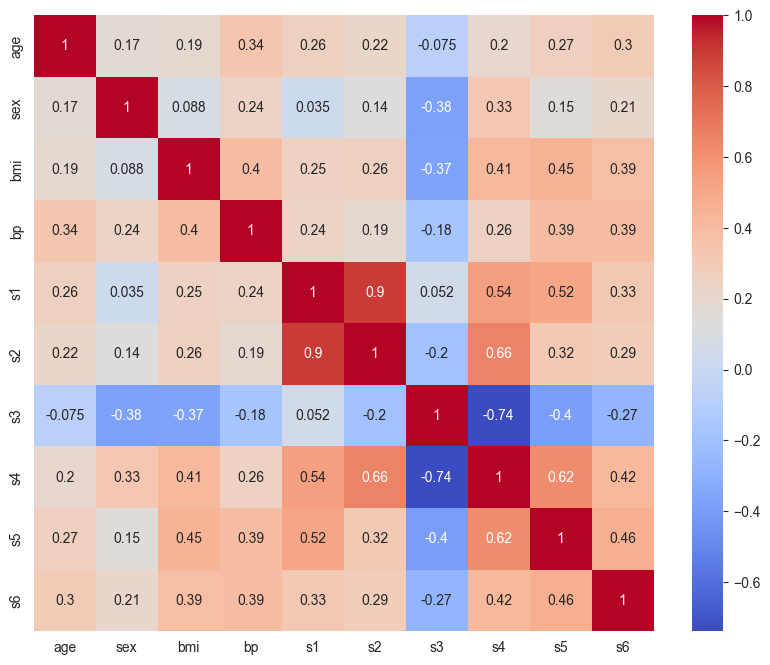

In [18]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    data=df.drop("target", axis=1).corr(),
    annot=True,
    cmap="coolwarm",
)

plt.show()

# Machine Learning Regression

## Decision Tree

[Reference] https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

### Dataset Definition

In [19]:
X = df.drop("target", axis=1)
y = df["target"]

# 먼저 train+valid와 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# train+valid를 다시 train과 valid로 분할 (75:25)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

In [20]:
print(f"데이터 분할 결과:")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Valid: {len(X_valid)} ({len(X_valid)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

데이터 분할 결과:
Train: 264 (59.7%)
Valid: 89 (20.1%)
Test: 89 (20.1%)


### Model (Vanilla)

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [23]:
model.score(X_train, y_train)

1.0

In [24]:
#print(model.intercept_, model.coef_)

#### Feature Importance

In [25]:
model.feature_importances_

array([0.08981708, 0.00592253, 0.43861624, 0.08517564, 0.04463861,
       0.04418316, 0.05650334, 0.05949104, 0.13289137, 0.04276099])

In [26]:
feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [27]:
_feature_importances = pd.Series(
    model.feature_importances_,
    index=feature_names,
)

_feature_importances

age   0.0898
sex   0.0059
bmi   0.4386
bp    0.0852
s1    0.0446
s2    0.0442
s3    0.0565
s4    0.0595
s5    0.1329
s6    0.0428
dtype: float64

<Axes: >

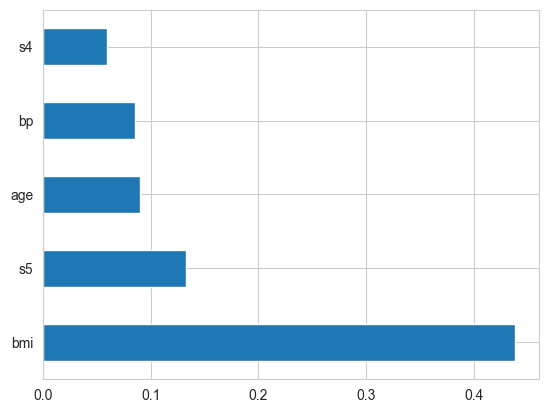

In [28]:
_feature_importances.nlargest().plot(kind="barh")

#### Prediction

In [29]:
# 각 셋에 대한 예측
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

In [30]:
# 각 셋의 성능 평가
def calculate_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {
        'Set': set_name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

In [31]:
# 모든 셋의 성능 계산
train_metrics = calculate_metrics(y_train, y_train_pred, 'Train')
valid_metrics = calculate_metrics(y_valid, y_valid_pred, 'Valid')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame([train_metrics, valid_metrics, test_metrics])
results_df = results_df.set_index('Set')

print("=== Train/Valid/Test 셋 성능 비교 ===")
print(results_df.round(4))

=== Train/Valid/Test 셋 성능 비교 ===
           R²       MSE    RMSE   MAPE
Set                                   
Train  1.0000    0.0000  0.0000 0.0000
Valid  0.2095 4330.7978 65.8088 0.3744
Test  -0.2659 6706.9101 81.8957 0.5430


#### Metrics

In [32]:
# 과적합 분석
print(f"\n=== 과적합 분석 ===")
train_valid_r2_diff = train_metrics['R²'] - valid_metrics['R²']
valid_test_r2_diff = valid_metrics['R²'] - test_metrics['R²']

print(f"Train-Valid R² 차이: {train_valid_r2_diff:.4f}")
print(f"Valid-Test R² 차이: {valid_test_r2_diff:.4f}")


=== 과적합 분석 ===
Train-Valid R² 차이: 0.7905
Valid-Test R² 차이: 0.4754


- 임계값 0.1 
    - 아래 코드에서 0.1로 비교하는 것은 고정 규칙이 아니라 경험적 가이드 입니다 
    - 모델/데이터별 차이가 있어 동일 기준으로 일관되게 적용할 수 없습니다 
    - 해당 파일에서는 우선적으로 경험적 가이드를 적용하여 진행합니다 
    
- 객관적 판단을 위해서는 "데이터 기반 임계값" 통한 비교 필요 => (모델 최적화 과정에서 확인) 
    - k-fold에서 val R^2의 표준편차 σ_val을 구해
    - 과적합 : (train_mean - val_mean) > max(0.05, 2*σ_val)
    - 일반화 문제 : |test - val_mean| > 2*σ_val

In [33]:
if train_valid_r2_diff > 0.1:
    print("⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 과적합 위험 낮음: 훈련 데이터와 검증 데이터 간 성능이 유사합니다.")

if valid_test_r2_diff > 0.1:
    print("⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 일반화 성능 양호: 검증 데이터와 테스트 데이터 간 성능이 유사합니다.")

⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.
⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.


In [34]:
# 모델 설명력 해석
print(f"\n=== 모델 설명력 해석 ===")
print(f"훈련 데이터 R²: {train_metrics['R²']:.4f} ({train_metrics['R²']*100:.2f}%)")
print(f"검증 데이터 R²: {valid_metrics['R²']:.4f} ({valid_metrics['R²']*100:.2f}%)")
print(f"테스트 데이터 R²: {test_metrics['R²']:.4f} ({test_metrics['R²']*100:.2f}%)")
print(f"→ 최종 테스트에서 모델이 {test_metrics['R²']*100:.1f}%의 분산을 설명합니다.")


=== 모델 설명력 해석 ===
훈련 데이터 R²: 1.0000 (100.00%)
검증 데이터 R²: 0.2095 (20.95%)
테스트 데이터 R²: -0.2659 (-26.59%)
→ 최종 테스트에서 모델이 -26.6%의 분산을 설명합니다.


In [35]:
# 오차 정확도 해석
print(f"\n=== 오차 정확도 해석 ===")
print(f"Train RMSE: {train_metrics['RMSE']:.2f}")
print(f"Valid RMSE: {valid_metrics['RMSE']:.2f}")
print(f"Test RMSE: {test_metrics['RMSE']:.2f}")
print(f"Test MAPE: {test_metrics['MAPE']:.4f} ({test_metrics['MAPE']*100:.2f}%)")
print(f"→ 최종 테스트에서 예측값이 실제값에 대해 평균적으로 ±{test_metrics['MAPE']*100:.1f}% 정도의 오차를 보입니다.")


=== 오차 정확도 해석 ===
Train RMSE: 0.00
Valid RMSE: 65.81
Test RMSE: 81.90
Test MAPE: 0.5430 (54.30%)
→ 최종 테스트에서 예측값이 실제값에 대해 평균적으로 ±54.3% 정도의 오차를 보입니다.


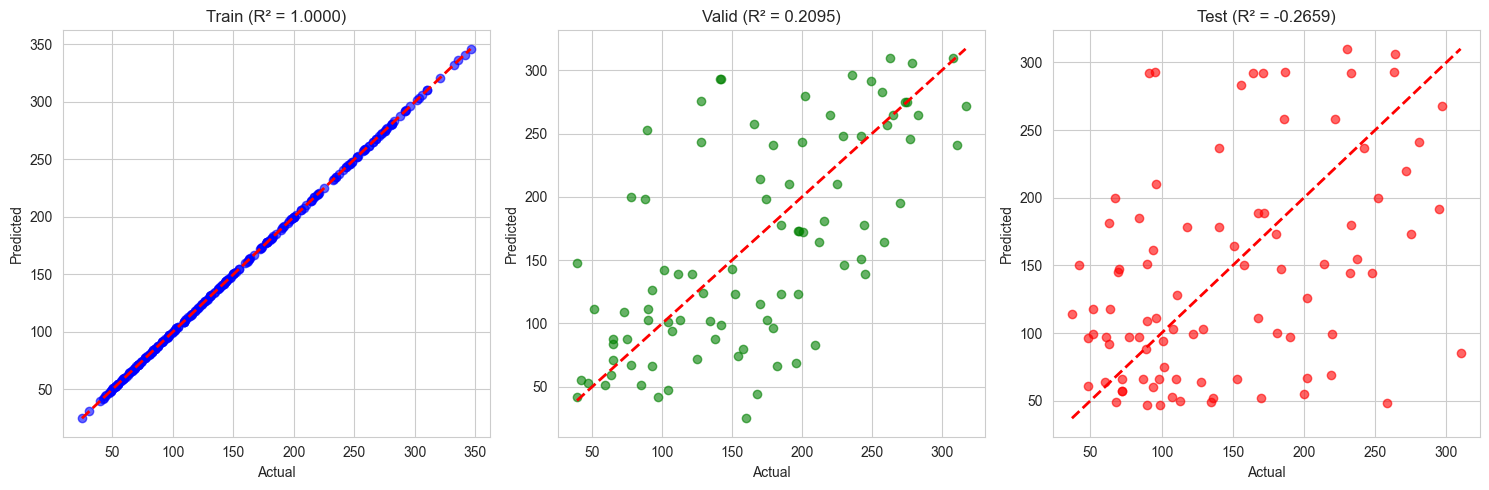

In [36]:
# 시각화: 실제값 vs 예측값 비교
plt.figure(figsize=(15, 5))

# 훈련 데이터
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color="blue")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Train (R² = {train_metrics['R²']:.4f})")

# 검증 데이터
plt.subplot(1, 3, 2)
plt.scatter(y_valid, y_valid_pred, alpha=0.6, color="green")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Valid (R² = {valid_metrics['R²']:.4f})")

# 테스트 데이터
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.6, color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test (R² = {test_metrics['R²']:.4f})")

plt.tight_layout()
plt.show()

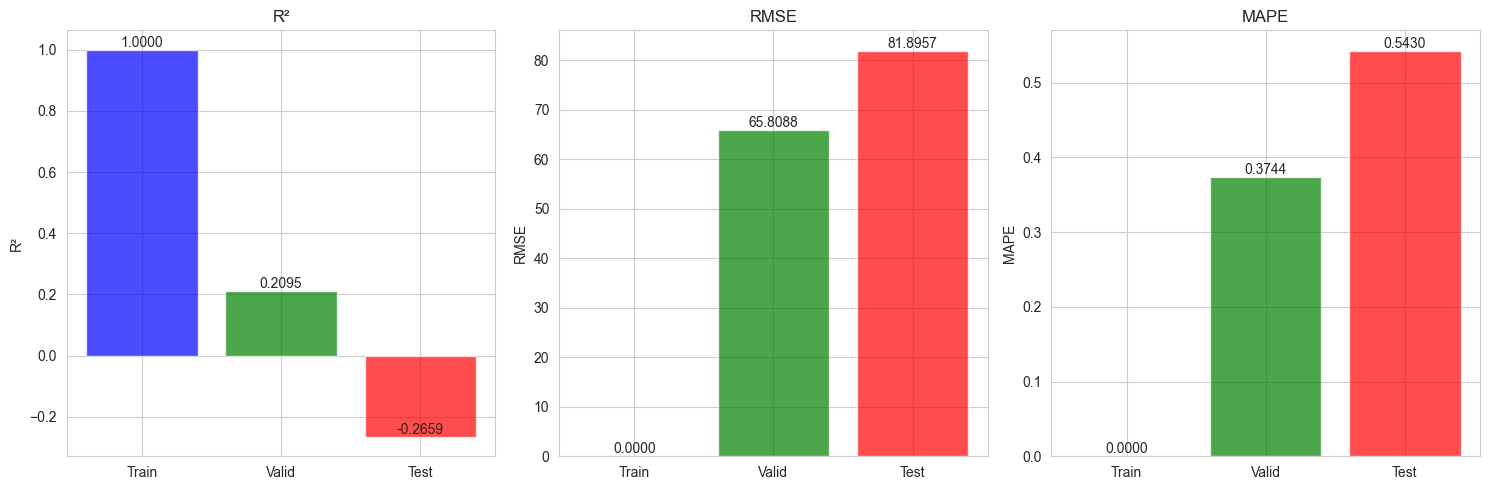

In [37]:
# 성능 지표 비교 차트
metrics_to_plot = ['R²', 'RMSE', 'MAPE']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics_to_plot):
    values = [train_metrics[metric], valid_metrics[metric], test_metrics[metric]]
    sets = ['Train', 'Valid', 'Test']
    
    bars = axes[i].bar(sets, values, color=['blue', 'green', 'red'], alpha=0.7)
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    
    # 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

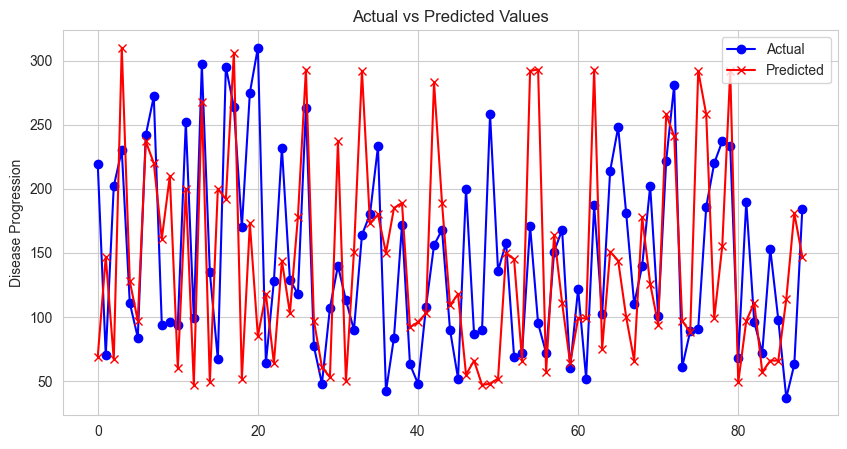

In [38]:
# actual vs predicted
plt.figure(figsize=(10, 5))

plt.plot(y_test.values, label="Actual", marker="o", color="blue")
plt.plot(y_test_pred, label="Predicted", marker="x", color="red")

plt.title("Actual vs Predicted Values")
plt.ylabel("Disease Progression")
plt.legend()
plt.show()

#### Tree Structure

In [39]:
from sklearn.tree import plot_tree

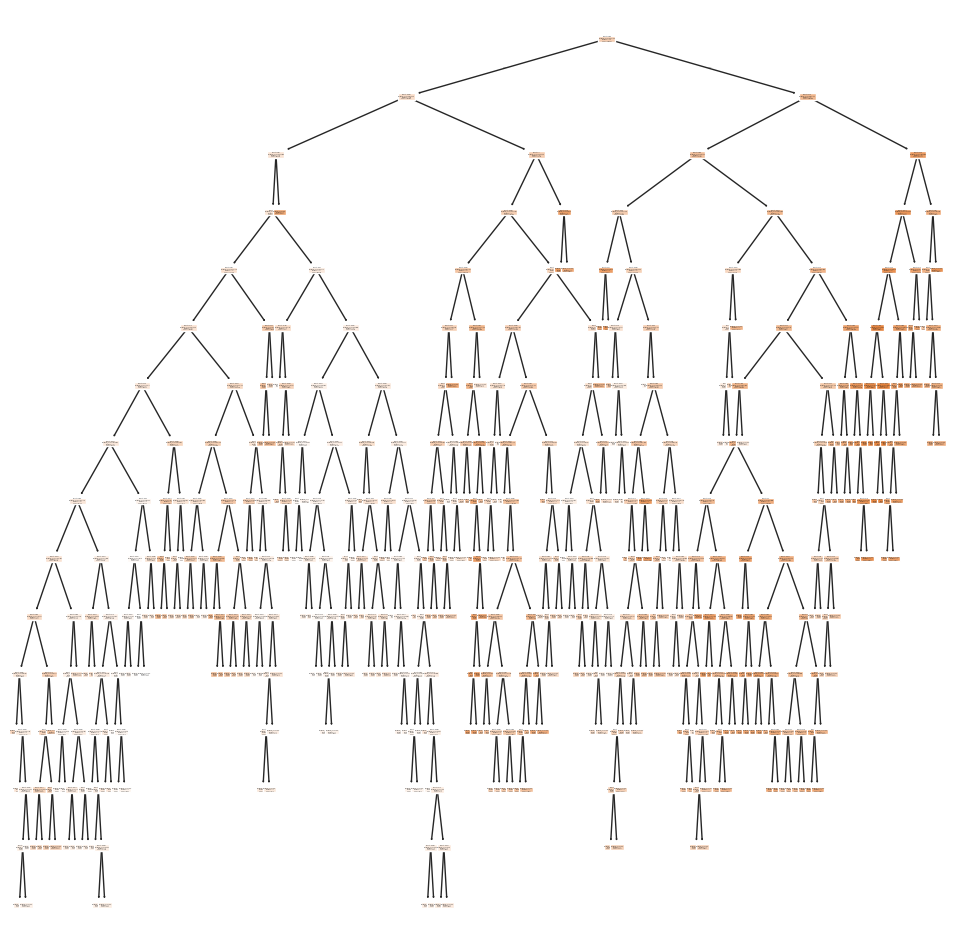

In [40]:
plt.figure(figsize=(12, 12))
plot_tree(model, filled=True)
plt.show()

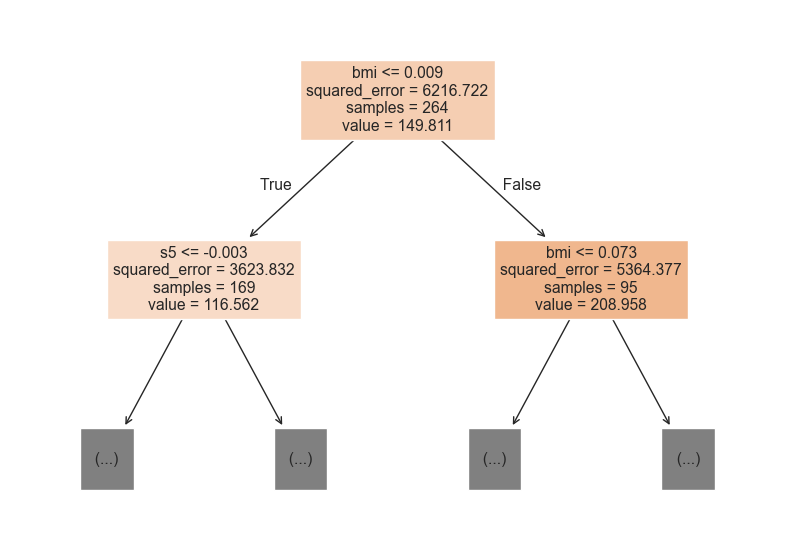

In [41]:
plt.figure(figsize=(10, 7))

plot_tree(
    model,
    filled=True,
    max_depth=1,
    feature_names=feature_names,
)

plt.show()

### Retraining (feat.Prunning)

In [42]:
models = {
    "DecisionTree": DecisionTreeRegressor(
        max_depth=3,          # 트리의 최대 깊이
        min_samples_split=5,  # 노트 분할 시, 최소한 5개의 샘플이 있어야 함
        min_samples_leaf=5,   # 리프 노드에는 최소한 5개의 샘플리 있어야 함
        random_state=RANDOM_STATE,
    )
}

In [43]:
model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [44]:
model.score(X_train, y_train)

1.0

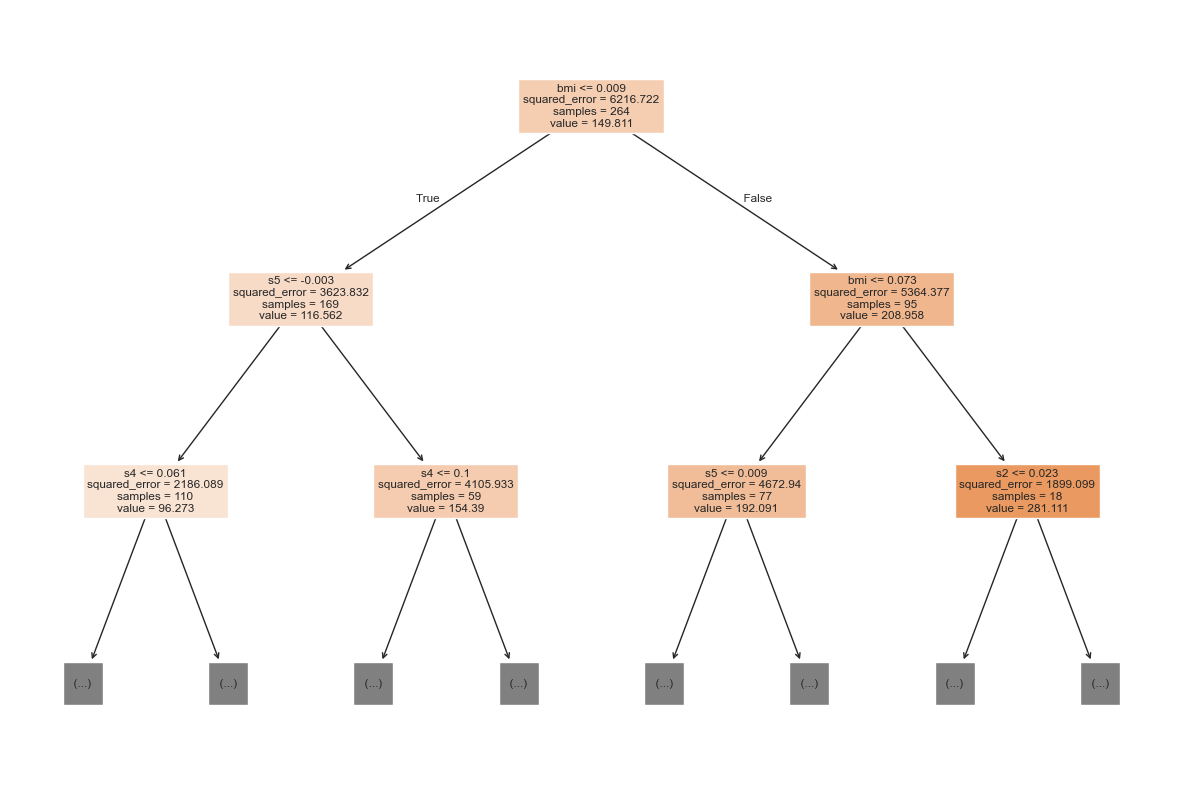

In [45]:
plt.figure(figsize=(15, 10))

plot_tree(
    model,
    filled=True,
    max_depth=2,  # 시각화 위해 제한
    feature_names=feature_names,
)

plt.show()

#### Feature Importance

In [46]:
_feature_importances = pd.Series(
    model.feature_importances_,
    index=feature_names,
)

_feature_importances

age   0.0898
sex   0.0059
bmi   0.4386
bp    0.0852
s1    0.0446
s2    0.0442
s3    0.0565
s4    0.0595
s5    0.1329
s6    0.0428
dtype: float64

<Axes: >

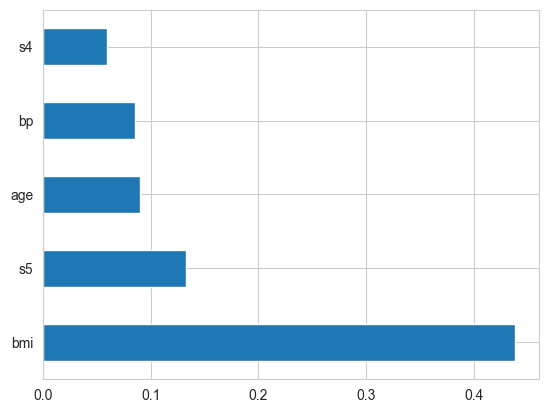

In [47]:
_feature_importances.nlargest().plot(kind="barh")

#### Prediction

In [48]:
# 각 셋에 대한 예측
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

In [49]:
# 모든 셋의 성능 계산
train_metrics = calculate_metrics(y_train, y_train_pred, 'Train')
valid_metrics = calculate_metrics(y_valid, y_valid_pred, 'Valid')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame([train_metrics, valid_metrics, test_metrics])
results_df = results_df.set_index('Set')

print("=== Train/Valid/Test 셋 성능 비교 ===")
print(results_df.round(4))

=== Train/Valid/Test 셋 성능 비교 ===
           R²       MSE    RMSE   MAPE
Set                                   
Train  1.0000    0.0000  0.0000 0.0000
Valid  0.2095 4330.7978 65.8088 0.3744
Test  -0.2659 6706.9101 81.8957 0.5430


In [50]:
# 과적합 분석
print(f"\n=== 과적합 분석 ===")
train_valid_r2_diff = train_metrics['R²'] - valid_metrics['R²']
valid_test_r2_diff = valid_metrics['R²'] - test_metrics['R²']

print(f"Train-Valid R² 차이: {train_valid_r2_diff:.4f}")
print(f"Valid-Test R² 차이: {valid_test_r2_diff:.4f}")

if train_valid_r2_diff > 0.1:
    print("⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 과적합 위험 낮음: 훈련 데이터와 검증 데이터 간 성능이 유사합니다.")

if valid_test_r2_diff > 0.1:
    print("⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 일반화 성능 양호: 검증 데이터와 테스트 데이터 간 성능이 유사합니다.")


=== 과적합 분석 ===
Train-Valid R² 차이: 0.7905
Valid-Test R² 차이: 0.4754
⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.
⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.


## 여러 알고리즘 결과 확인

(대상) Decision Tree, randomForest, Lasso, Ridge, XGB, LGBM

1. 위 알고리즘 중 가장 최적의 예측 성능을 보이는 알고리즘 확인 
    - 현재 단계에서는 cross validation은 고려하지 않음  
2. 최적의 성능을 보이는 알고리즘의 feature importance 확인 
3. 최적의 모델에 대해서만 예측 성능 확인 (RMSE)

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Models

In [52]:
models = {
    "DecisionTree": DecisionTreeRegressor(
        max_depth=4,              # 트리 최대 깊이 제한으로 과적합 방지
        min_samples_split=10,     # 노드 분할 시 최소 10개 샘플 필요
        min_samples_leaf=5,       # 리프 노드에는 최소 5개 샘플 필요
        random_state=RANDOM_STATE,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=100,         # 100개의 의사결정 트리로 앙상블 구성
        max_depth=8,              # 개별 트리 최대 깊이 
        min_samples_split=5,      # 노드 분할 시 최소 5개 샘플 필요
        min_samples_leaf=2,       # 리프 노드에는 최소 2개 샘플 필요
        random_state=RANDOM_STATE,
    ),
    "Lasso": Lasso(
        alpha=0.01,               # 정규화 강도 (작을수록 덜 정규화)
        random_state=RANDOM_STATE,
    ),
    "Ridge": Ridge(
        alpha=0.1,                # 정규화 강도 (작을수록 덜 정규화)
        random_state=RANDOM_STATE,
    ),
    "XGBRegressor": XGBRegressor(
        n_estimators=100,         # 100개의 부스팅 라운드
        max_depth=6,              # 트리 최대 깊이
        learning_rate=0.1,        # 학습률 (작을수록 안정적이지만 느림)
        subsample=0.8,            # 샘플링 비율 (과적합 방지)
        colsample_bytree=0.8,     # 특성 샘플링 비율 (과적합 방지) 
        random_state=RANDOM_STATE,
    ),
    "LGBMRegressor": LGBMRegressor(
        n_estimators=100,         # 100개의 부스팅 라운드
        max_depth=6,              # 트리 최대 깊이
        learning_rate=0.1,        # 학습률
        subsample=0.8,            # 샘플링 비율
        colsample_bytree=0.8,     # 특성 샘플링 비율
        random_state=RANDOM_STATE,
        force_col_wise=True,      # 경고 메시지 방지
    ),
}

In [53]:
# 모든 모델의 성능을 train, valid, test 셋에서 평가# 모든 모델의 성능을 train, valid, test 셋에서 평가
all_results = []

for model_name, model in models.items():
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 각 셋에 대한 예측
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
    
    # 각 셋의 성능 계산
    train_metrics = calculate_metrics(y_train, y_train_pred, f'{model_name}_Train')
    valid_metrics = calculate_metrics(y_valid, y_valid_pred, f'{model_name}_Valid')
    test_metrics = calculate_metrics(y_test, y_test_pred, f'{model_name}_Test')
    
    all_results.extend([train_metrics, valid_metrics, test_metrics])

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('Set')

print("=== 모든 모델의 Train/Valid/Test 성능 비교 ===")
print(results_df.round(4))

# 모델별로 정리하여 가독성 향상
print("\n=== 모델별 성능 요약 ===")
model_names = ["DecisionTree", "RandomForest", "Lasso", "Ridge", "XGBRegressor", "LGBMRegressor"]

for model_name in model_names:
    print(f"\n[{model_name}]")
    train_row = results_df.loc[f'{model_name}_Train']
    valid_row = results_df.loc[f'{model_name}_Valid']
    test_row = results_df.loc[f'{model_name}_Test']
    
    print(f"  Train - R²: {train_row['R²']:.4f}, RMSE: {train_row['RMSE']:.4f}")
    print(f"  Valid - R²: {valid_row['R²']:.4f}, RMSE: {valid_row['RMSE']:.4f}")
    print(f"  Test  - R²: {test_row['R²']:.4f}, RMSE: {test_row['RMSE']:.4f}")


[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 264, number of used features: 10
[LightGBM] [Info] Start training from score 149.810606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

#### 결과 해석

**전체 성능 비교**
- XGBRegressor와 RandomForest는 과적합이 의심됨 (Train R² > 0.85, Test R² < 0.45)
- Ridge와 Lasso가 가장 안정적인 성능을 보임

### Metrics

In [54]:
# 모든 모델의 성능을 train, valid, test 셋에서 평가
test_results = []
model_names = ["DecisionTree", "RandomForest", "Lasso", "Ridge", "XGBRegressor", "LGBMRegressor"]

for model_name in model_names:
    test_row = results_df.loc[f'{model_name}_Test']
    test_results.append({
        'Model': model_name,
        'R²': test_row['R²'],
        'RMSE': test_row['RMSE'],
        'MSE': test_row['MSE'],
        'MAPE': test_row['MAPE']
    })

# 테스트 성능을 R² 기준으로 정렬
test_comparison_df = pd.DataFrame(test_results).sort_values('R²', ascending=False)

print("=== 테스트 성능 비교 (R² 기준 내림차순) ===")
print(test_comparison_df.round(4))

# 최고 성능 모델 출력
best_model_name = test_comparison_df.iloc[0]['Model']
best_r2 = test_comparison_df.iloc[0]['R²']
best_rmse = test_comparison_df.iloc[0]['RMSE']

print(f"\n최고 성능 모델: {best_model_name}")
print(f"R²: {best_r2:.4f}, RMSE: {best_rmse:.4f}")

=== 테스트 성능 비교 (R² 기준 내림차순) ===
           Model     R²    RMSE       MSE   MAPE
3          Ridge 0.4558 53.6941 2883.0570 0.3663
2          Lasso 0.4514 53.9115 2906.4545 0.3665
1   RandomForest 0.4318 54.8663 3010.3134 0.4014
5  LGBMRegressor 0.4168 55.5853 3089.7227 0.4032
4   XGBRegressor 0.3810 57.2664 3279.4421 0.4015
0   DecisionTree 0.3113 60.4061 3648.9000 0.4290

최고 성능 모델: Ridge
R²: 0.4558, RMSE: 53.6941


#### 테스트 성능 분석

**최고 성능 모델 선택**
- Ridge Regression이 R² 0.4558로 1위를 차지하여 최고 성능 모델로 선정됨

### Best Model

In [60]:
# 테스트 성능 기준으로 최고 모델 선택
best_model_name = test_comparison_df.iloc[0]['Model']
best_model = models[best_model_name]


print(f"선택된 최고 성능 모델: {best_model_name}")
print(f"테스트 R²: {test_comparison_df.iloc[0]['R²']:.4f}")
print(f"테스트 RMSE: {test_comparison_df.iloc[0]['RMSE']:.4f}")

선택된 최고 성능 모델: Ridge
테스트 R²: 0.4558
테스트 RMSE: 53.6941


### Feature Importance

=== Ridge Coefficient Importance (절댓값) ===
bmi   486.3793
s5    403.8977
bp    281.9268
sex   201.4770
s3    185.6912
s4    161.8174
s2    125.0469
s6    111.1299
s1    103.1486
age    39.9838
dtype: float64


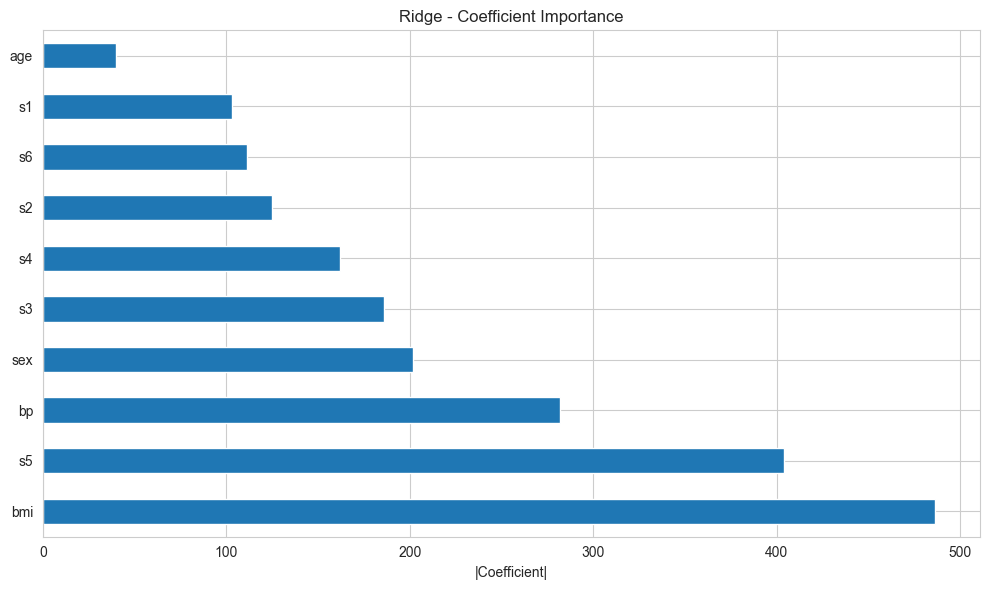

In [56]:
# Best Model의 feature importance 분석
if hasattr(best_model, 'feature_importances_'):
    best_feature_importances = pd.Series(
        best_model.feature_importances_,
        index=feature_names,
    ).sort_values(ascending=False)
    
    print(f"=== {best_model_name} Feature Importance ===")
    print(best_feature_importances.round(4))
    
    # 시각화
    plt.figure(figsize=(10, 6))
    best_feature_importances.plot(kind='barh')
    plt.title(f'{best_model_name} - Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # 선형 모델의 경우 계수의 절댓값 사용
    best_coef_importance = pd.Series(
        np.abs(best_model.coef_),
        index=feature_names,
    ).sort_values(ascending=False)
    
    print(f"=== {best_model_name} Coefficient Importance (절댓값) ===")
    print(best_coef_importance.round(4))
    
    # 시각화
    plt.figure(figsize=(10, 6))
    best_coef_importance.plot(kind='barh')
    plt.title(f'{best_model_name} - Coefficient Importance')
    plt.xlabel('|Coefficient|')
    plt.tight_layout()
    plt.show()

else:
    print(f"{best_model_name} 모델은 feature importance를 지원하지 않습니다.")

#### Feature Importance 해석

**Ridge 회귀 계수 중요도 분석**
- BMI(486.38)가 가장 강력한 예측 인자로 당뇨병 진행도에 최대 영향
- S5(403.90), BP(281.93)가 그 다음으로 중요한 생리학적 지표
- Age(39.98)는 상대적으로 낮은 영향력을 보여 생활습관 요인이

### Prediction

In [57]:
# Best Model로 예측 수행
y_train_pred_best = best_model.predict(X_train)
y_valid_pred_best = best_model.predict(X_valid)
y_test_pred_best = best_model.predict(X_test)

print(f"=== {best_model_name} 예측 완료 ===")
print(f"Train 예측 샘플 수: {len(y_train_pred_best)}")
print(f"Valid 예측 샘플 수: {len(y_valid_pred_best)}")
print(f"Test 예측 샘플 수: {len(y_test_pred_best)}")

=== Ridge 예측 완료 ===
Train 예측 샘플 수: 264
Valid 예측 샘플 수: 89
Test 예측 샘플 수: 89


In [58]:
# Best Model로 성능 계산
train_metrics_best = calculate_metrics(y_train, y_train_pred_best, 'Train')
valid_metrics_best = calculate_metrics(y_valid, y_valid_pred_best, 'Valid')
test_metrics_best = calculate_metrics(y_test, y_test_pred_best, 'Test')

# 결과를 DataFrame으로 정리
best_results_df = pd.DataFrame([train_metrics_best, valid_metrics_best, test_metrics_best])
best_results_df = best_results_df.set_index('Set')

print(f"=== {best_model_name} 최종 성능 ===")
print(best_results_df.round(4))

# 최종 테스트 성능 요약
print(f"\n최종 테스트 성능:")
print(f"R²: {test_metrics_best['R²']:.4f}")
print(f"RMSE: {test_metrics_best['RMSE']:.4f}")
print(f"MAPE: {test_metrics_best['MAPE']:.4f}")

=== Ridge 최종 성능 ===
          R²       MSE    RMSE   MAPE
Set                                  
Train 0.5105 3042.8483 55.1620 0.4105
Valid 0.5201 2629.0688 51.2744 0.3042
Test  0.4558 2883.0570 53.6941 0.3663

최종 테스트 성능:
R²: 0.4558
RMSE: 53.6941
MAPE: 0.3663


#### 최종 성능 평가

**최고 모델 성능 검증**
- Ridge 모델의 Train/Valid/Test 성능 일관성 확인으로 안정적 모델임을 검증
- 테스트 R² 0.4558로 당뇨병 진행도의 45.58% 분산 설명력 확보

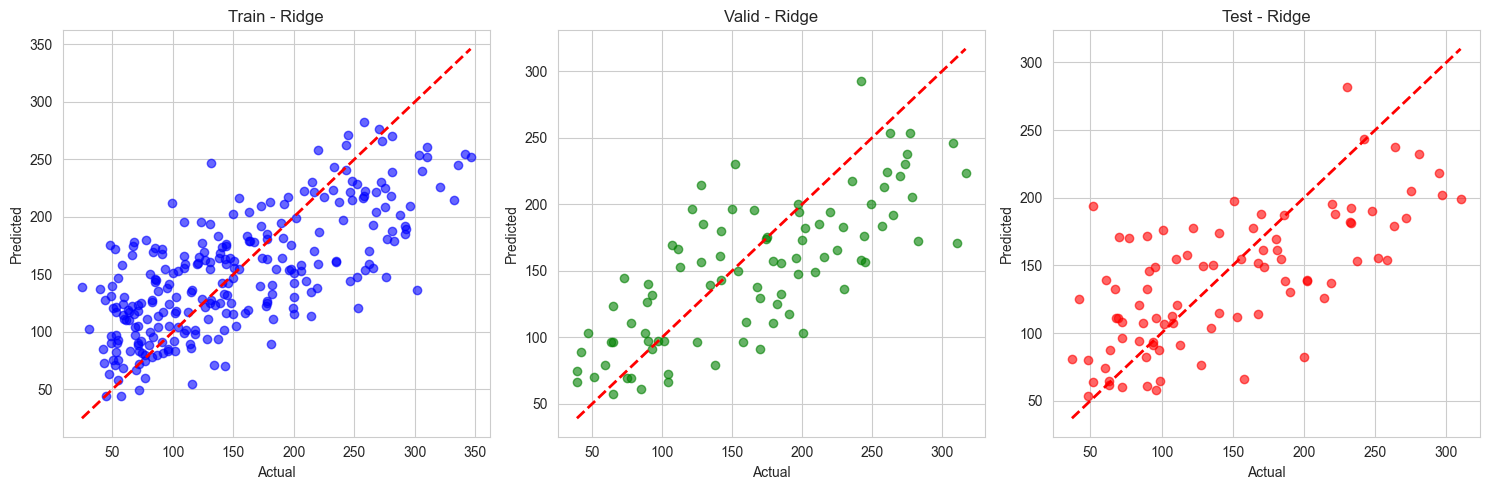

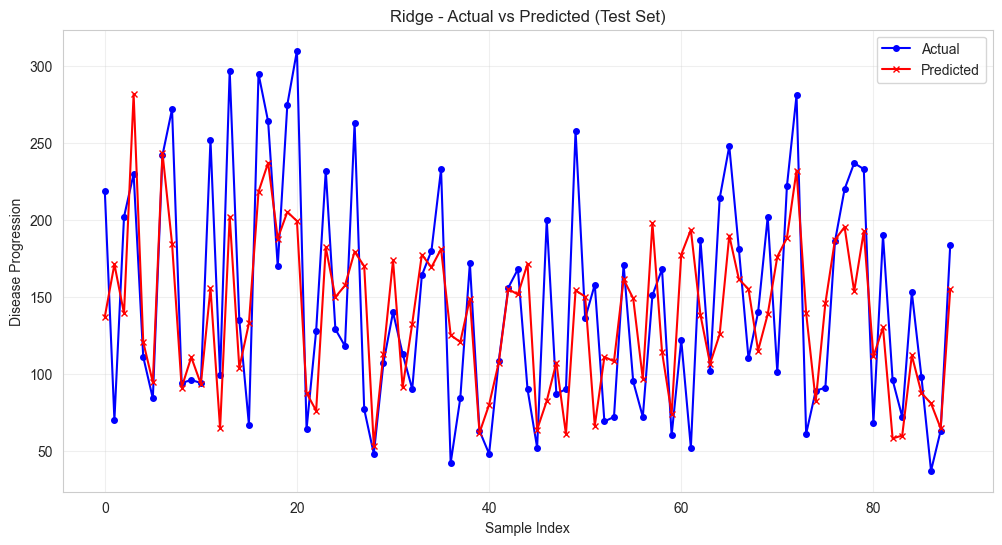

In [59]:
# actual vs predicted visualization
plt.figure(figsize=(15, 5))

# 훈련 데이터
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred_best, alpha=0.6, color="blue")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Train - {best_model_name}")

# 검증 데이터
plt.subplot(1, 3, 2)
plt.scatter(y_valid, y_valid_pred_best, alpha=0.6, color="green")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Valid - {best_model_name}")

# 테스트 데이터
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_best, alpha=0.6, color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test - {best_model_name}")

plt.tight_layout()
plt.show()

# 시계열 형태로 실제값 vs 예측값 비교
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker="o", color="blue", markersize=4)
plt.plot(y_test_pred_best, label="Predicted", marker="x", color="red", markersize=4)
plt.title(f"{best_model_name} - Actual vs Predicted (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Disease Progression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 예측 시각화 분석

**Actual vs Predicted 산점도**
- Train/Valid/Test 모든 셋에서 대각선 근처에 분포하여 예측 정확도 양호
- Test 셋에서 일부 산점이 대각선에서 벗어나지만 전체적으로 일관된 패턴 유지

**시계열 비교 그래프**
- 실제값과 예측값이 대부분 구간에서 유사한 패턴으로 변화
- 극값(최고/최저점)에서 예측 오차가 다소 발생하지만 전반적 추세 잘 포착

# End of Documents